In [26]:
## this example is referred from https://medium.com/@siromermer/predicting-objects-motion-with-kalman-filter-and-fast-algorithm-2278c551670b

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time 
import os

In [27]:
#path to video
vid_path=os.path.join(".", "data","helicopter.mp4")
video = cv2.VideoCapture(vid_path)

if not video.isOpened():
    print("Error: Could not open video file.")

#read only the first frame for drawing a rectanle for desired object
ret,frame = video.read()


# I am giving  big random numbers for x_min and y_min because if you initialize them as zeros whatever coordinate you go minimum will be zero 
x_min,y_min,x_max,y_max=36000,36000,0,0

In [29]:
def coordinat_chooser(event,x,y,flags,param):
    global go , x_min , y_min, x_max , y_max

    # when you click the right button, it will provide coordinates for variables
    if event==cv2.EVENT_LBUTTONDOWN:
        
        # if current coordinate of x lower than the x_min it will be new x_min , same rules apply for y_min 
        x_min=min(x,x_min) 
        y_min=min(y,y_min)

         # if current coordinate of x higher than the x_max it will be new x_max , same rules apply for y_max
        x_max=max(x,x_max)
        y_max=max(y,y_max)

        # draw rectangle
        cv2.rectangle(frame,(x_min,y_min),(x_max,y_max),(0,255,0),1)


    """
        if you didn't like your rectangle (maybe if you made some misscliks),  reset the coordinates with the middle button of your mouse
        if you press the middle button of your mouse coordinates will reset and you can give a new 2-point pair for your rectangle
    """
    if event==cv2.EVENT_MBUTTONDOWN:
        print("reset coordinate  data")
        x_min,y_min,x_max,y_max=36000,36000,0,0

cv2.namedWindow('coordinate_screen')
# Set mouse handler for the specified window, in this case, "coordinate_screen" window
cv2.setMouseCallback('coordinate_screen',coordinat_chooser)

while True:
    cv2.imshow("coordinate_screen",frame) # show only first frame 
    
    k = cv2.waitKey(5) & 0xFF # after drawing rectangle press ESC   
    if k == 27:
        cv2.destroyAllWindows()
        
        break


reset coordinate  data


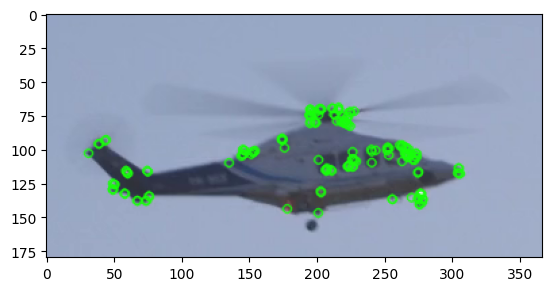

In [30]:
# take region of interest ( take inside of rectangle )
roi_image=frame[y_min+2:y_max-2,x_min+2:x_max-2]
roi_rgb=cv2.cvtColor(roi_image,cv2.COLOR_BGR2RGB)

# convert roi to grayscale, SIFT Algorithm works with grayscale images
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 

# # Initialize the FAST detector and BRIEF descriptor extractor
# fast = cv2.FastFeatureDetector_create(threshold=1)
# brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()


# # detect keypoints
# keypoints_1 = fast.detect(roi_gray, None)
# # descriptors
# keypoints_1, descriptors_1 = brief.compute(roi_gray, keypoints_1)

#Initialize the ORB detector (which combines FAST for detection and BRIEF for description)
orb = cv2.ORB_create(nfeatures=1000)

# Detect keypoints and compute descriptors using ORB
keypoints = orb.detect(roi_gray, None)  # Detect keypoints
keypoints_1, descriptors_1 = orb.compute(roi_gray, keypoints)  # Compute descriptors

# draw keypoints for visualizing
keypoints_image = cv2.drawKeypoints(roi_rgb, keypoints_1, outImage=None, color=(23, 255, 10))
# display keypoints
plt.imshow(keypoints_image,cmap="gray")

In [31]:
# matcher object
bf = cv2.BFMatcher()

def detect_target_fast(frame):
    # convert frame to gray scale 
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # # Detect keypoints using FAST
    # keypoints_2 = fast.detect(frame_gray, None)

    # # Compute descriptors using BRIEF
    
    #Initialize the ORB detector (which combines FAST for detection and BRIEF for description)
    orb = cv2.ORB_create(nfeatures=1000)

    # Detect keypoints and compute descriptors using ORB
    keypoints = orb.detect(frame_gray, None)  # Detect keypoints
    keypoints_2, descriptors_2 = orb.compute(frame_gray, keypoints)  # Compute descriptors

    """
    Compare the keypoints/descriptors extracted from the 
    first frame (from target object) with those extracted from the current frame.
    """
    if descriptors_2 is not None:
        matches = bf.match(descriptors_1, descriptors_2)
        
        if matches:
            # Initialize sums for x and y coordinates
            sum_x = 0
            sum_y = 0
            match_count = 0
            
            for match in matches:
                # .trainIdx gives keypoint index from current frame 
                train_idx = match.trainIdx
                
                # current frame keypoints coordinates
                pt2 = keypoints_2[train_idx].pt
                
                # Sum the x and y coordinates
                sum_x += pt2[0]
                sum_y += pt2[1]
                match_count += 1
            
            # Calculate average of the x and y coordinates
            avg_x = sum_x / match_count
            avg_y = sum_y / match_count
            
    return int(avg_x),int(avg_y)

In [32]:
#initialize the kalman filter
# Initialize Kalman filter parameters
kalman = cv2.KalmanFilter(4, 2)   
 
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03  # Process noise
kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.5  # Measurement noise

In [33]:
# Startcapturing the video from file
cap = cv2.VideoCapture(vid_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Predict the new position of the ball
    predicted = kalman.predict()
    predicted_x, predicted_y = int(predicted[0]), int(predicted[1])
    predicted_dx, predicted_dy = predicted[2], predicted[3]  # Predicted velocity

    print(predicted_x, predicted_y )
    print(f"Predicted velocity: (dx: {predicted_dx}, dy: {predicted_dy})")

    
    # Detect the ball in the current frame
    hel_pos = detect_target_fast(frame)
    
    if hel_pos:
        measured_x, measured_y = hel_pos
        # Correct the Kalman Filter with the actual measurement
        kalman.correct(np.array([[np.float32(measured_x)], [np.float32(measured_y)]]))
        # Draw the detected ball
        cv2.circle(frame, (measured_x, measured_y), 6, (0, 255, 0), 2) # green --> correct position
    
    # Draw the predicted position (Kalman Filter result)
    cv2.circle(frame, (predicted_x, predicted_y), 8, (0, 0, 255), 2) # red --> predicted position

    # Show the frame
    cv2.imshow("Kalman Ball Tracking", frame)
    
    # Break on 'q' key press
    if cv2.waitKey(30) & 0xFF == ord('q'):  # 30 ms delay for smooth playback
        break

cap.release()
cv2.destroyAllWindows()

0 0
Predicted velocity: (dx: [0.], dy: [0.])
32 55
Predicted velocity: (dx: [0.], dy: [0.])
142 237
Predicted velocity: (dx: [27.922707], dy: [46.128605])
351 588
Predicted velocity: (dx: [78.74356], dy: [131.99602])
557 962
Predicted velocity: (dx: [112.89911], dy: [196.63258])
679 1168
Predicted velocity: (dx: [115.146675], dy: [198.91676])
725 1241
Predicted velocity: (dx: [98.34756], dy: [168.11322])
716 1240
Predicted velocity: (dx: [72.400856], dy: [127.3148])
688 1189
Predicted velocity: (dx: [48.103848], dy: [84.274])
656 1135
Predicted velocity: (dx: [28.769869], dy: [50.92698])
612 1103
Predicted velocity: (dx: [11.179341], dy: [30.641811])
592 1057
Predicted velocity: (dx: [3.441194], dy: [12.119753])
573 1022
Predicted velocity: (dx: [-1.995177], dy: [0.6020529])
557 1008
Predicted velocity: (dx: [-5.2493596], dy: [-2.9407575])
551 977
Predicted velocity: (dx: [-5.5696464], dy: [-9.519393])
547 994
Predicted velocity: (dx: [-5.119565], dy: [-3.2759871])
529 1028
Predicted v